# Calculating vertical velocities
A guide to using the package XApRES to load existing xarrays and calculate vertical velocities

## Load the package and set up workspace

In [78]:
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
importlib.reload(ApRESDefs)

<module 'ApRESDefs' from '/home/jovyan/xapres_package/notebooks/test_notes/../../xapres_package/ApRESDefs.py'>

Initialize the XApRES package

In [2]:
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    21:07:06 	 ApRESDefs.py @function _setup_logging line 494 - Stream logging level set to DEBUG
DEBUG    21:07:06 	 ApRESDefs.py @function _setup_logging line 495 - Add console handler to logger
DEBUG    21:07:06 	 ApRESDefs.py @function _setup_logging line 508 - File logging level set to DEBUG


Load in data from A101

In [3]:
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")


In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34877")
client

<Client: 'tcp://127.0.0.1:34877' processes=4 threads=8, memory=29.39 GiB>

Looking at structure of A101 data

In [5]:
ds_101.profile_stacked

<xarray.DataArray 'profile_stacked' (time: 11723, profile_range: 6658,
                                     attenuator_setting_pair: 2)>
dask.array<open_dataset-e3f551d4f1d1299ea5d6b4a9322b7eb6profile_stacked, shape=(11723, 6658, 2), dtype=float64, chunksize=(20, 6658, 2), chunktype=numpy.ndarray>
Coordinates:
    AFGain         (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator     (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number   (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    filename       (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-22T19:40:20 ... 2022-09-25T1...
Dimensions without coordinates: attenuator_setting_pair

## Calculate vertical velocities for a pair of stacked bursts
The function looks like `generate_range_diff(self, data1, data2, win_cor, step, range_ext=None, win_wrap=10, thresh=0.9, uncertainty='noise_phasor')`.

Let's start by looking at 2 consecutive bursts

In [97]:
s1 = ds_101.profile_stacked.isel(attenuator_setting_pair=1,time=100).compute()
s2 = ds_101.profile_stacked.isel(attenuator_setting_pair=1,time=101).compute()

Plotting them together shows that they look quite similar

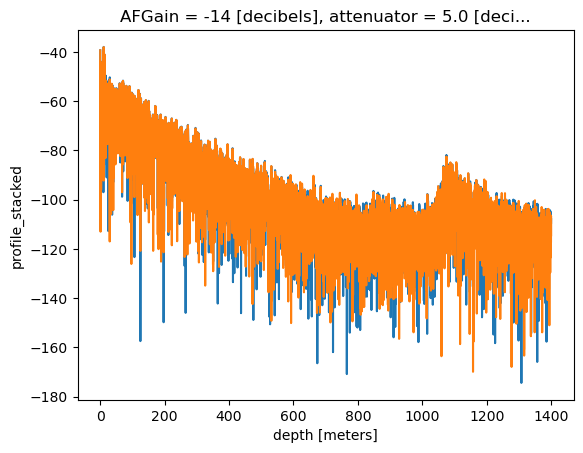

In [98]:
xa.dB(s1).plot()
xa.dB(s2).plot()

Calculating and plotting the velocities show that it is essentially zero. There is a lot of uncertainty near the surface and deep in the ice, and that uncertainty shrinks once we near the bed. Keep in mind that changing the windowing/steps changes these results and uncertainties by quite a bit.

In [99]:
vels = xa.generate_range_diff(s1,s2,30,30)
vels

INFO     22:48:55 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 901.0s


<xarray.Dataset>
Dimensions:        (profile_range: 221)
Coordinates:
    AFGain         int64 -14
    attenuator     float64 5.0
    burst_number   int64 86
    filename       <U83 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-...
  * profile_range  (profile_range) float64 3.154 9.463 ... 1.385e+03 1.391e+03
    time           datetime64[ns] 2022-05-27T13:06:26
Data variables:
    velocity       (profile_range) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    uncertainty    (profile_range) float64 -0.0001593 -0.0002312 ... -4.431e-05

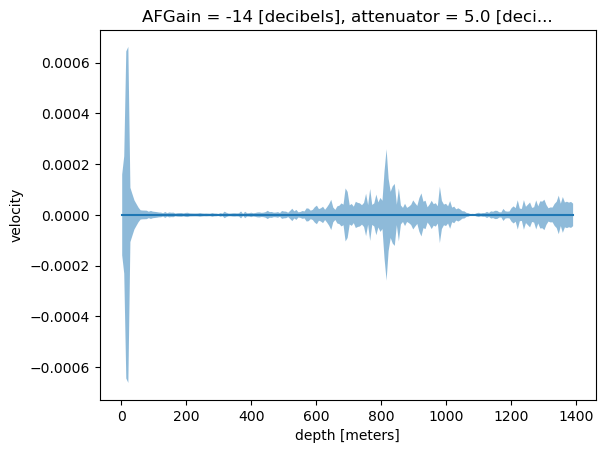

In [100]:
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

Now let's look at some individual bursts further apart. These are roughly a week apart.

In [101]:
s1 = ds_101.profile_stacked.isel(attenuator_setting_pair=1,time=100).compute()
s2 = ds_101.profile_stacked.isel(attenuator_setting_pair=1,time=800).compute()

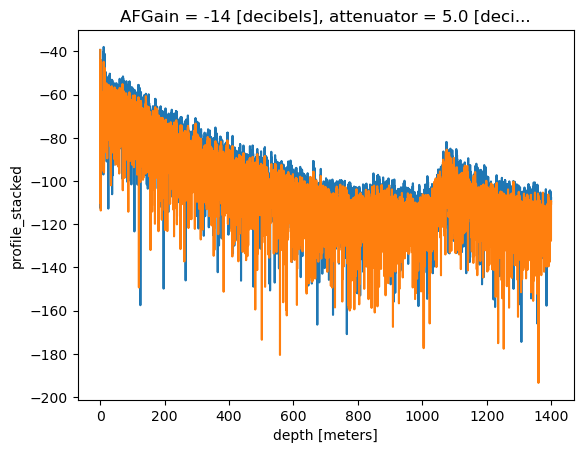

In [102]:
xa.dB(s1).plot()
xa.dB(s2).plot()

In [103]:
vels = xa.generate_range_diff(s1,s2,30,30)

INFO     22:51:04 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 630001.0s


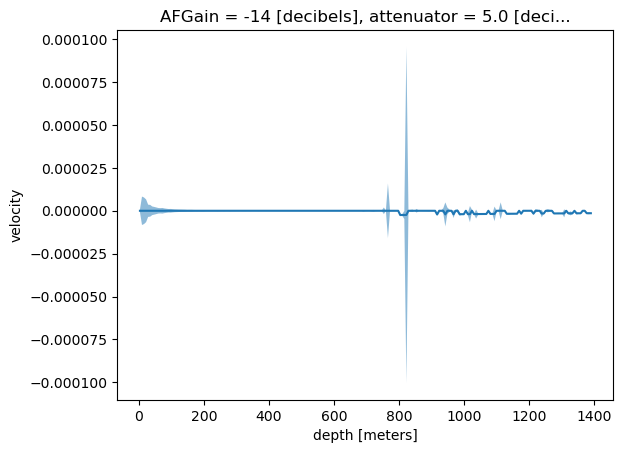

In [106]:
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

Even further apart. These are roughly 4 months apart.

In [107]:
s1 = ds_101.profile_stacked.isel(attenuator_setting_pair=1,time=50).compute()
s2 = ds_101.profile_stacked.isel(attenuator_setting_pair=1,time=11700).compute()

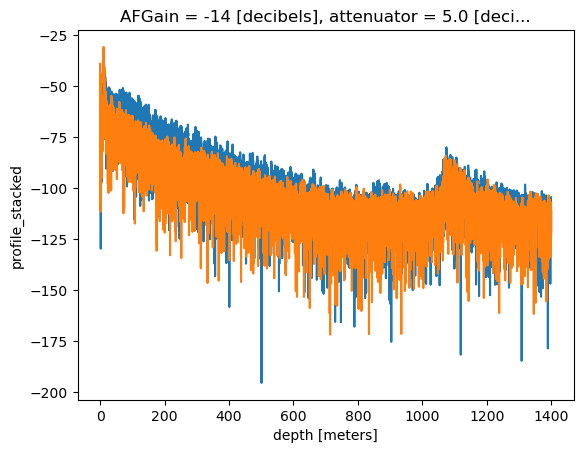

In [108]:
xa.dB(s1).plot()
xa.dB(s2).plot()

In [109]:
vels = xa.generate_range_diff(s1,s2,30,30)

INFO     22:52:58 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 10484086.0s


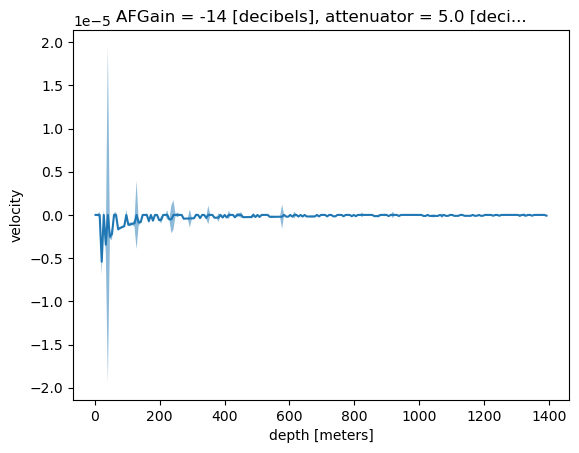

In [110]:
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

Now I am trying to stack each day's worth of bursts. Xarray's resample function is quite useful for this.

In [79]:
profiles_daily = ds_101.isel(attenuator_setting_pair=1,chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1D').mean(dim='time').compute()
profiles_daily

<xarray.DataArray 'profile' (time: 127, profile_range: 6658)>
array([[ 1.08319566e-02, -4.84155694e-06, -6.44138064e-03, ...,
        -1.16093174e-06,  1.08729768e-07,  1.65559711e-06],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [ 1.09606364e-02,  3.12258391e-06, -6.52006378e-03, ...,
         9.46330199e-07,  9.55721199e-07, -3.32416033e-07],
       [ 1.09768647e-02,  6.66199517e-06, -6.53384900e-03, ...,
        -1.67543336e-06, -3.81746965e-07,  2.03533661e-06],
       [ 1.10257198e-02,  2.24650830e-06, -6.55736704e-03, ...,
         1.45122164e-06,  2.96771133e-06, -1.42171205e-06]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-22 2022-05-23 ... 2022-09-25
    attenuator     float64 5.0
    AFGain         int64 -14

I want to focus on the days around the suspected lake drainage

In [47]:
test = profiles_daily.sel(time=xr.date_range('2022-07-01','2022-07-20'))

INFO     22:55:14 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 1641600.0s


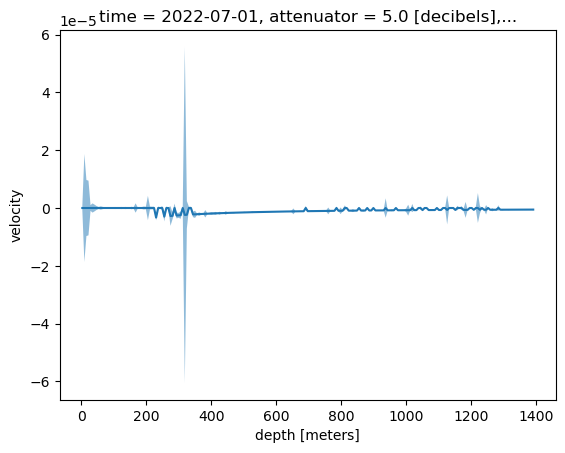

In [111]:
s1 = test.isel(time=0)
s2 = test.isel(time=19)
vels = xa.generate_range_diff(s1,s2,30,30)
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

Although the below range plots don't show much, there seems to be a slight kink of sorts in the vertical velocity profile from the days before and after the drainage

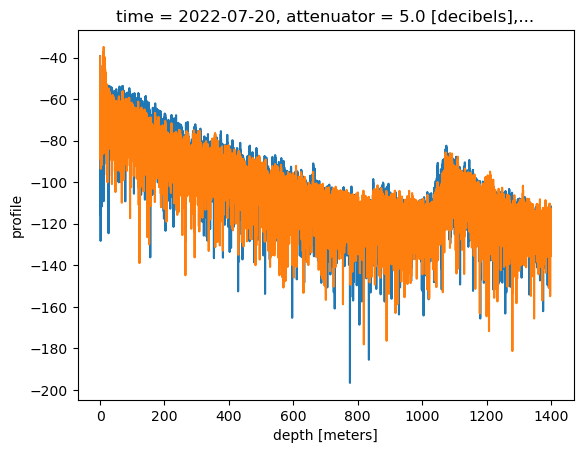

In [94]:
xa.dB(s1).plot()
xa.dB(s2).plot()

Now let's look at the vertical velocities between each day during this period. We see that between the 13th and 14th, there's an appearance of faster velocities at depth. Interesting, and maybe I can use this to look at an hourly resample.

In [82]:
vels_total = []
stagger = 1
for i in range(0,len(test.time)-stagger):
    s1 = test.isel(time = i)
    s2 = test.isel(time = i+stagger)
    vels = xa.generate_range_diff(s1,s2,30,30)
    vels_total.append(vels)
vels_array = xr.concat(vels_total,dim='time') 

INFO     22:39:34 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:35 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:36 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:37 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:38 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:40 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:41 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:42 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:43 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:39:44 	 ApRESDefs.py @function generate_ran

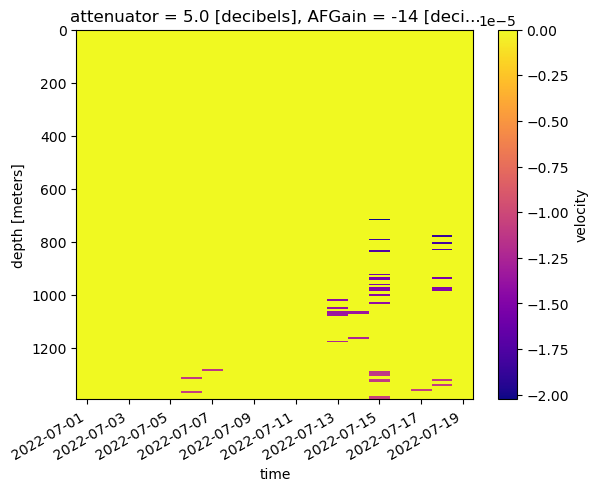

In [83]:
vels_array.velocity.plot(x='time',cmap='plasma')
plt.gca().invert_yaxis()

Trying hourly resample:

In [115]:
profiles_hourly = ds_101.isel(attenuator_setting_pair=1,chirp_num=range(1,19)).mean(dim='chirp_num').profile.resample(time='1H').mean(dim='time').compute()
profiles_hourly

<xarray.DataArray 'profile' (time: 3020, profile_range: 6658)>
array([[ 1.08369286e-02, -3.76468781e-06, -6.44415856e-03, ...,
        -9.97046373e-08,  3.20037408e-06,  4.71417617e-08],
       [ 1.08328996e-02, -4.89124558e-06, -6.44234054e-03, ...,
        -1.04506497e-06, -9.25624075e-07,  1.76510116e-06],
       [ 1.08314642e-02, -5.23683276e-06, -6.44103275e-03, ...,
        -2.31017249e-06, -3.20878152e-07,  2.21946429e-06],
       ...,
       [ 1.10315501e-02,  5.05550744e-06, -6.56408289e-03, ...,
         1.41332433e-06,  1.60850708e-06, -4.40179041e-07],
       [ 1.10262347e-02,  4.75117184e-06, -6.56066333e-03, ...,
         1.62331312e-06,  2.81273769e-06, -2.00704277e-06],
       [ 1.10240357e-02,  4.68901430e-06, -6.55927530e-03, ...,
        -1.49477589e-07,  2.09713586e-06,  3.00086071e-08]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-22T19:00:00 ... 2022-09-25T1...
    attenuator     float64 5.0
    AFGain         int64 -14

Select even finer window range surrounding suspected drainage

In [120]:
date_range = xr.date_range('2022-07-13T12:00:00.000000000','2022-07-15T12:00:00.000000000',freq='H')
profiles_hourly_crop =profiles_hourly.sel(time=date_range)

In [121]:
profiles_hourly_crop

<xarray.DataArray 'profile' (time: 49, profile_range: 6658)>
array([[ 1.07176259e-02,  2.12050074e-05, -6.34223169e-03, ...,
        -5.36265437e-06, -6.13371437e-07,  2.11022959e-06],
       [ 1.07812182e-02, -3.24088112e-06, -6.42012768e-03, ...,
        -5.64547708e-07,  1.53472040e-06,  4.06572424e-07],
       [ 1.06931253e-02,  9.45375877e-06, -6.37252837e-03, ...,
        -1.35748471e-06, -5.10388484e-07,  5.95273560e-07],
       ...,
       [ 1.08349981e-02, -3.67508561e-06, -6.45072789e-03, ...,
        -3.64966935e-07, -1.81839047e-06,  2.12163176e-06],
       [ 1.08177577e-02, -6.92883320e-07, -6.43697502e-03, ...,
        -4.91982257e-08, -4.03024189e-06,  2.19880231e-06],
       [ 1.08215614e-02, -5.13467177e-06, -6.44043051e-03, ...,
        -2.61891130e-06, -7.62027958e-07,  2.82035697e-06]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-07-13T12:00:00 ... 2022-07-15T1...
    attenuator     float64 5.0
    AFGain         int64 -14

In [122]:
vels_total = []
stagger = 1
for i in range(0,len(profiles_hourly_crop.time)-stagger):
    s1 = profiles_hourly_crop.isel(time = i)
    s2 = profiles_hourly_crop.isel(time = i+stagger)
    vels = xa.generate_range_diff(s1,s2,30,30)
    vels_total.append(vels)
vels_array = xr.concat(vels_total,dim='time') 

INFO     23:06:13 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:14 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:15 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:17 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:18 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:19 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:20 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:21 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:22 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 3600.0s
INFO     23:06:23 	 ApRESDefs.py @function generate_range_diff l

Plotting hourly velocities. Is there a signal here? Maybe.

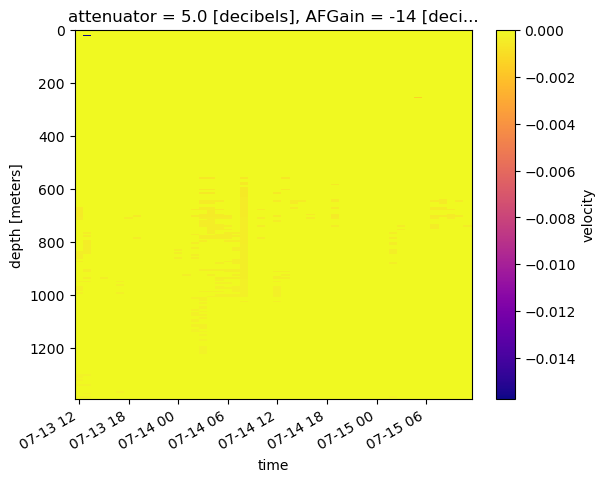

In [123]:
vels_array.velocity.plot(x='time',cmap='plasma')
plt.gca().invert_yaxis()

Taking individual hours from before and after, there is something happening at the base, but the errors are high and it's not smooth

INFO     23:12:04 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 43200.0s


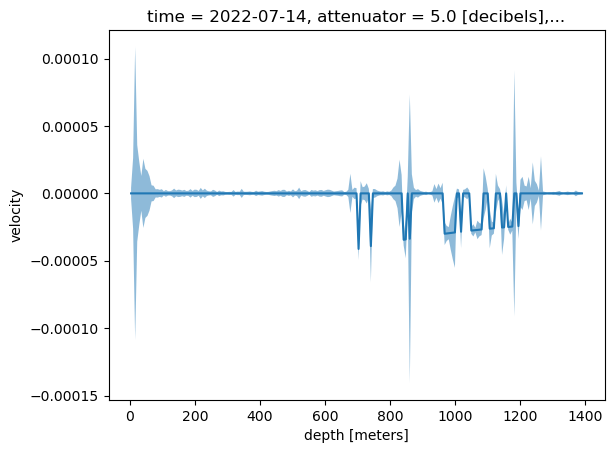

In [130]:
s1 = profiles_hourly_crop.sel(time = '2022-07-14T00:00:00.000000000')
s2 = profiles_hourly_crop.sel(time = '2022-07-14T12:00:00.000000000')
vels = xa.generate_range_diff(s1,s2,30,30)
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

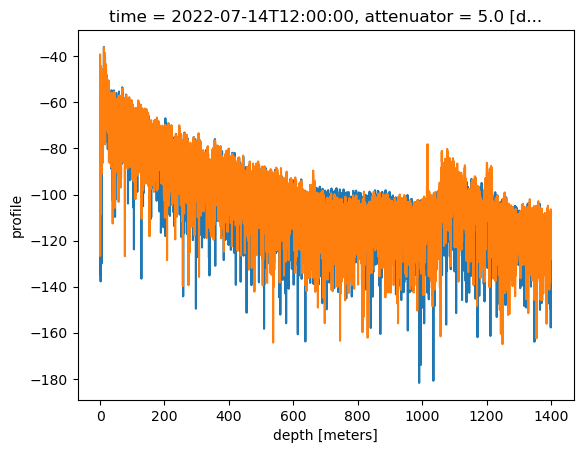

In [133]:
xa.dB(s1).plot()
xa.dB(s2).plot()

# Now attempting to loop through whole data series

In [84]:
vels_total = []
stagger = 1
for i in range(0,len(profiles_daily.time)-stagger):
    s1 = profiles_daily.isel(time = i)
    s2 = profiles_daily.isel(time = i+stagger)
    vels = xa.generate_range_diff(s1,s2,30,30)
    vels_total.append(vels)
vels_array = xr.concat(vels_total,dim='time') 

INFO     22:40:26 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:27 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:28 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:29 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:30 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:31 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:32 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:34 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:35 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 86400.0s
INFO     22:40:36 	 ApRESDefs.py @function generate_ran

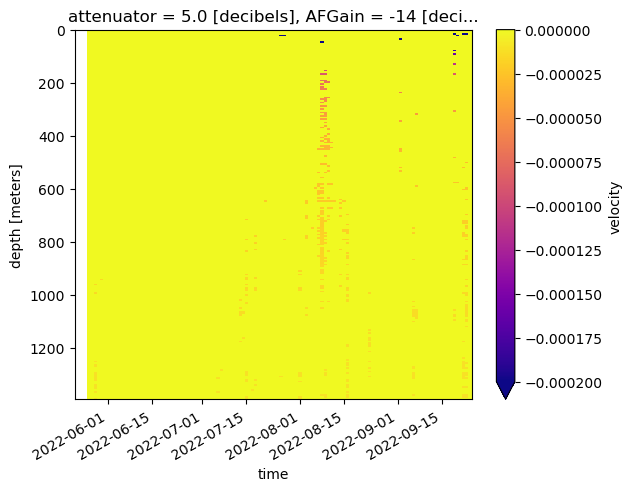

In [85]:
vels_array.velocity.plot(x='time',cmap='plasma',vmin=-0.0002)
plt.gca().invert_yaxis()

In [54]:
vels_array

<xarray.Dataset>
Dimensions:        (profile_range: 332, time: 126)
Coordinates:
  * profile_range  (profile_range) float64 2.103 6.309 ... 1.39e+03 1.394e+03
  * time           (time) datetime64[ns] 2022-05-22 2022-05-23 ... 2022-09-24
    attenuator     float64 5.0
    AFGain         int64 -14
Data variables:
    velocity       (time, profile_range) float64 nan nan nan ... -0.0 -0.0 -0.0
    uncertainty    (time, profile_range) float64 nan nan ... -4.139e-07